# 目标
- 计算并绘制直方图
- （自适应）直方图均衡化
- OpenCV函数：cv2.calcHist(), cv2.equalizeHist()

# 教程
## 啥叫直方图
直方图简单来说就是图像中每个像素值的个数统计，比如说一副灰度图中像素值为0的有多少个，1的有多少个……直方图是一种分析图片的手段：
![](http://blog.codec.wang/cv2_understand_histogram.jpg)
在计算直方图之前，有几个术语先来了解一下：
- dims：要计算的通道数，对于灰度图dims=1，普通彩色图dims=3
- range：要计算的像素值范围，一般为[0,256)
- bins：子区段数目，如果我们统计0255每个像素值，bins=256；如果划分区间，比如015, 1631…240255这样16个区间，bins=16

## 计算直方图
OpenCV和Numpy中都提供了计算直方图的函数，我们对比下它们的性能。

## OpenCV中直方图计算
使用cv2.calcHist(images, channels, mask, histSize, ranges)计算，其中：
- 参数1：要计算的原图，以方括号的传入，如：[img]
- 参数2：类似前面提到的dims，灰度图写[0]就行，彩色图B/G/R分别传入[0]/[1]/[2]
- 参数3：要计算的区域，计算整幅图的话，写None
- 参数4：前面提到的bins
- 参数5：前面提到的range

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('hist.jpg', 0)
hist = cv2.calcHist([img], [0], None, [256], [0, 256]) # 性能：0.025288 s

## Numpy中直方图计算
也可用Numpy的函数计算，其中ravel()函数将二维矩阵展平变成一维数组，之前有提到过：

In [ ]:
hist, bins = np.histogram(img.ravel(), 256, [0, 256])  # 性能：0.020628 s

经验之谈：Numpy中还有一种更高效的方式：（还记得怎么评估性能吗：番外篇：代码性能优化）

In [ ]:
hist = np.bincount(img.ravel(), minlength=256)  # 性能：0.003163 s

计算出直方图之后，怎么把它画出来呢？

## 绘制直方图
其实Matplotlib自带了一个计算并绘制直方图的功能，不需要用到上面的函数：

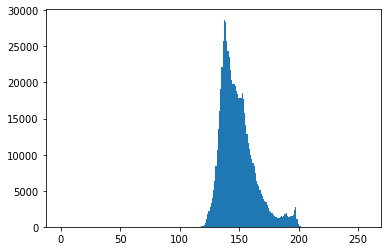

In [3]:
plt.hist(img.ravel(), 256, [0, 256])
plt.show()

当然，也可以用前面计算出来的结果绘制

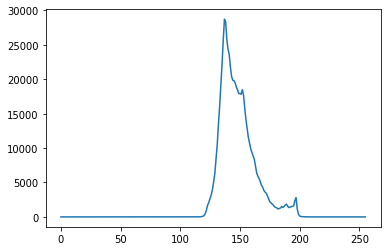

In [4]:
plt.plot(hist)
plt.show()

从直方图上可以看到图片的大部分区域集中在150偏白的附近，这其实并不是很好的效果，下面我们来看看如何改善它。

使用OpenCV的画线功能也可以画直方图，不过太麻烦了，有兴趣的可以看下官方示例：hist.py。

## 直方图均衡化
一副效果好的图像通常在直方图上的分布比较均匀，直方图均衡化就是用来改善图像的全局亮度和对比度。其实从观感上就可以发现，前面那幅图对比度不高，偏灰白。对均衡化算法感兴趣的同学可参考：维基百科：直方图均衡化

![](http://blog.codec.wang/cv2_understand_histogram_equalization.jpg)

In [6]:
equ = cv2.equalizeHist(img)

OpenCV中用cv2.equalizeHist()实现均衡化。我们把两张图片并排显示，对比一下：

In [8]:

cv2.imshow('equalization', np.hstack((img, equ)))  # 并排显示
cv2.waitKey(0)

-1

![](http://blog.codec.wang/cv2_before_after_equalization_histogram.jpg)
可以看到均衡化后图片的亮度和对比度效果明显好于原图。

## 自适应均衡化
不难看出来，直方图均衡化是应用于整幅图片的，会有什么问题呢？看下图
![](http://blog.codec.wang/cv2_understand_adaptive_histogram.jpg)
很明显，因为全局调整亮度和对比度的原因，脸部太亮，大部分细节都丢失了。

自适应均衡化就是用来解决这一问题的：它在每一个小区域内（默认8×8）进行直方图均衡化。当然，如果有噪点的话，噪点会被放大，需要对小区域内的对比度进行了限制，所以这个算法全称叫：对比度受限的自适应直方图均衡化CLAHE(Contrast Limited Adaptive Histogram Equalization)。

In [10]:
# 自适应均衡化，参数可选
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl1 = clahe.apply(img)

-1

![](http://blog.codec.wang/cv2_adaptive_histogram.jpg)
